In [1]:
from google.colab import files
uploaded = files.upload()

import os,stat
try:    os.mkdir('/root/.kaggle')
except: pass

for fn in uploaded.keys():
  os.chmod(fn,stat.S_IRWXU)
  os.replace(fn,"/root/.kaggle/kaggle.json")

Saving kaggle.json to kaggle.json


In [1]:
%cd /content/drive/MyDrive/ColabWork/MedicalWork/

/content/drive/MyDrive/ColabWork/MedicalWork


In [2]:
!ls

chest_xray  models  mymedical.ipynb  README.md


In [3]:
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force


100% 2.29G/2.29G [00:25<00:00, 92.7MB/s]
100% 2.29G/2.29G [00:25<00:00, 96.2MB/s]


In [3]:
!pip install fastai -q --upgrade


     |████████████████████████████████| 194kB 11.6MB/s 
     |████████████████████████████████| 61kB 5.6MB/s 


In [17]:
from fastai import *

In [4]:
from fastai.vision.all import *

In [15]:
from fastai.callback import *


In [5]:
def valid_func(o: Path):
    return 'test' in str(o)

def label_func(o: Path):
    if 'virus' in o.name:
        return 'pneumonia'
    if 'bacteria' in o.name:
        return 'pneumonia'
    return 'normal'

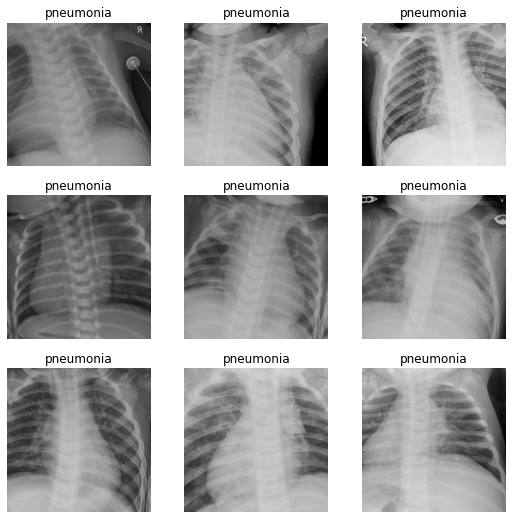

In [6]:
data_dir=Path('chest_xray')
sz=256
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

db = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=FuncSplitter(valid_func),
                 get_y=label_func,
                 item_tfms=Resize(sz*2),
                 batch_tfms=[*aug_transforms(size=sz), Normalize.from_stats(*stats)])

data = db.dataloaders(data_dir,bs=128)
data.show_batch(max_n=9)

In [25]:
learn.dls.bs=256
learn.dls.bs

256

In [26]:
len(data.train_ds)

10406

In [27]:
len(data.valid_ds)

1248

In [7]:
model_dir = Path('.').absolute() / 'models'


In [17]:
model_dir.mkdir(exist_ok=True)

In [19]:
SaveModelCallback??

In [8]:
learn = cnn_learner(data,
                    resnet50,
                    metrics=error_rate,
#                    bn_wd=False,
                    loss_func=LabelSmoothingCrossEntropy(),
                    cbs=[BnFreeze,
                          SaveModelCallback(monitor='error_rate', fname='best_error'),
                          ShowGraphCallback,
                         ],
                    model_dir=model_dir,
                   ).to_fp16()


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [9]:
# Loading the trained model
learn.load('stage_1')

In [28]:
def train(learn, name, lr, n_epochs=2, **kwargs): # must be called kwargs, not kw_args or anything else
    learn.fit_one_cycle(n_epochs, lr, **kwargs)
    learn.save(name)

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=1.5848931980144698e-06)

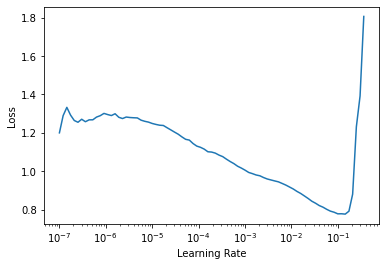

In [29]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time
0,0.579726,0.630215,0.227564,12:37
1,0.321473,0.440051,0.144231,04:09


Better model found at epoch 0 with error_rate value: 0.22756409645080566.


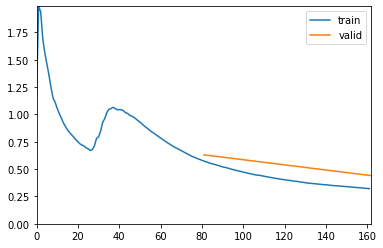

Better model found at epoch 1 with error_rate value: 0.14423076808452606.


In [30]:
lr=1e-1
train(learn, 'stage_1', lr)


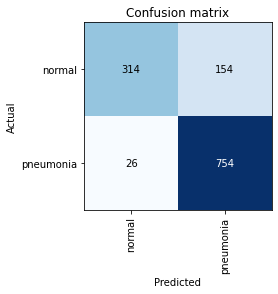

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [11]:
model = learn.model.eval()


In [42]:
learn.dls.valid_ds.

(#2) [<bound method L.cat of TfmdLists: [Path('chest_xray/chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0031-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0021-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0023-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0019-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0022-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0025-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0010-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0007-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0029-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0015-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0013-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0009-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL/IM-0005-0001.jpeg'), Path('chest_xray/chest_xray/test/NORMAL

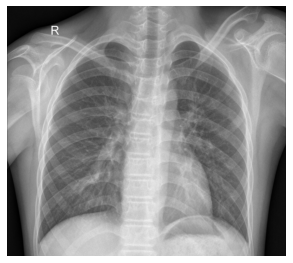

In [21]:
idx=0
x,y = learn.dls.valid_ds[idx]
x.show()

In [47]:
t = learn.dls.valid_ds[0][0]; t.shape


(1916, 2144)

In [39]:
t = learn.dls.valid_ds[102]; t


(PILImage mode=RGB size=2352x2166, TensorCategory(0))

In [28]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,1,3,3)/6

In [29]:
k.shape

torch.Size([1, 1, 3, 3])

In [44]:
pred = learn.predict(t)
cls = int(pred[1])
pred, cls

(('normal', tensor(0), tensor([0.8585, 0.1415])), 0)

In [ ]:
learn.dls.valid_ds.o

In [50]:
b, _ = learn.dls.one_batch()


In [52]:
b.shape

(128, 3, 256, 256)

In [ ]:
learn.dls.de

In [ ]:
#b, _ = learn.dls.one_batch()
#b, _ = learn.data.one_item(img)

img = Image(learn.data.denorm(b[0])[0])
b = b.cuda()
img

In [61]:
type(b[0])
#img=Image(b[0])

fastai.torch_core.TensorImage

In [55]:
with hook_output(model[0]) as hook_a:
    with hook_output(model[0], grad=True) as hook_g:
        preds = model(b[0].unsqueeze(0))
        preds[0, cls].backward()
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

In [56]:
grad_chan = grad.mean(1).mean(1)
mult = ((acts * grad_chan[..., None, None])).sum(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


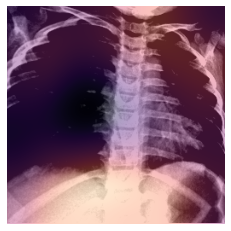

In [62]:
_,ax = plt.subplots()
b[0].show(ax)
ax.imshow(mult, alpha=0.4, extent=(0,256, 256,0), interpolation='bicubic', cmap='magma')